Convolution Neural Networks

In [ ]:
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt
from tensorflow.keras import utils

In [ ]:
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import sys
import os
import random

In [ ]:
import zipfile
import os
import glob

In [ ]:
from tensorflow.keras import utils
import inspect

Importing Data and simple preprocessing.

In [ ]:
zip_ref = zipfile.ZipFile('/content/drive/MyDrive/datasets/Bees.zip', 'r') #Opens the zip file in read mode
zip_ref.extractall('/content/drive/MyDrive/datasets/tmp') #Extracts the files into the /tmp folder
zip_ref.close()

In [ ]:
bees_txt=pd.read_csv('/content/drive/MyDrive/datasets/bee_data.csv')
bees_txt.head()

,file,date,time,location,zip code,subspecies,health,pollen_carrying,caste
0,041_066.png,8/28/18,16:07,"Alvin, TX, USA",77511,-1,hive being robbed,False,worker
1,041_072.png,8/28/18,16:07,"Alvin, TX, USA",77511,-1,hive being robbed,False,worker
2,041_073.png,8/28/18,16:07,"Alvin, TX, USA",77511,-1,hive being robbed,False,worker
3,041_067.png,8/28/18,16:07,"Alvin, TX, USA",77511,-1,hive being robbed,False,worker
4,041_059.png,8/28/18,16:07,"Alvin, TX, USA",77511,-1,hive being robbed,False,worker


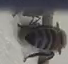

In [ ]:
from IPython.display import Image
Image("/content/drive/MyDrive/datasets/tmp/bee_imgs/bee_imgs/001_043.png")

In [ ]:
image_files = list(os.listdir('/content/drive/MyDrive/datasets/tmp/bee_imgs/bee_imgs/'))
print(len(image_files))

5172


In [ ]:
file_names = list(bees_txt['file'])
print("Matching image names: {}".format(len(set(file_names).intersection(image_files))))

Matching image names: 5172


In [ ]:
from keras.preprocessing.image import ImageDataGenerator

In [ ]:
from keras import optimizers
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten, MaxPool2D, Dropout, BatchNormalization,LeakyReLU
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical
import tensorflow
from sklearn.model_selection import train_test_split
from sklearn import metrics

In [ ]:
import imageio
import skimage
import skimage.io
import skimage.transform
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array, array_to_img

In [ ]:
bees=pd.read_csv('/content/drive/MyDrive/datasets/tmp/bee_data.csv', 
                index_col=False,  
                parse_dates={'datetime':[1,2]},
                dtype={'subspecies':'category', 'health':'category','caste':'category'})

In [ ]:
bees.head()

,datetime,file,location,zip code,subspecies,health,pollen_carrying,caste
0,2018-08-28 16:07:00,041_066.png,"Alvin, TX, USA",77511,-1,hive being robbed,False,worker
1,2018-08-28 16:07:00,041_072.png,"Alvin, TX, USA",77511,-1,hive being robbed,False,worker
2,2018-08-28 16:07:00,041_073.png,"Alvin, TX, USA",77511,-1,hive being robbed,False,worker
3,2018-08-28 16:07:00,041_067.png,"Alvin, TX, USA",77511,-1,hive being robbed,False,worker
4,2018-08-28 16:07:00,041_059.png,"Alvin, TX, USA",77511,-1,hive being robbed,False,worker


In [ ]:
img_folder='/content/drive/MyDrive/datasets/tmp/bee_imgs/bee_imgs/'
img_width=100
img_height=100
img_channels=3

In [ ]:
def read_img(file):
    img = skimage.io.imread(img_folder + file)
    img = skimage.transform.resize(img, (img_width, img_height), mode='reflect')
    return img[:,:,:img_channels]

In [ ]:
bees.dropna(inplace=True)
#remove null values
img_exists = bees['file'].apply(lambda f: os.path.exists(img_folder + f))
bees = bees[img_exists]

bees.head()

,datetime,file,location,zip code,subspecies,health,pollen_carrying,caste
0,2018-08-28 16:07:00,041_066.png,"Alvin, TX, USA",77511,-1,hive being robbed,False,worker
1,2018-08-28 16:07:00,041_072.png,"Alvin, TX, USA",77511,-1,hive being robbed,False,worker
2,2018-08-28 16:07:00,041_073.png,"Alvin, TX, USA",77511,-1,hive being robbed,False,worker
3,2018-08-28 16:07:00,041_067.png,"Alvin, TX, USA",77511,-1,hive being robbed,False,worker
4,2018-08-28 16:07:00,041_059.png,"Alvin, TX, USA",77511,-1,hive being robbed,False,worker


In [ ]:
bees['health'].unique

<bound method Series.unique of 0       hive being robbed
1       hive being robbed
2       hive being robbed
3       hive being robbed
4       hive being robbed
              ...        
5167              healthy
5168              healthy
5169              healthy
5170              healthy
5171              healthy
Name: health, Length: 5172, dtype: category
Categories (6, object): ['Varroa, Small Hive Beetles', 'ant problems', 'few varrao, hive beetles', 'healthy',
                         'hive being robbed', 'missing queen']>

We see that There exist 6 different categories for bee health.

In [ ]:
def split_balance(bees, field_name):
    #split into train test and val
    train_bees, test_bees = train_test_split(bees, random_state=24)
    train_bees, val_bees = train_test_split(train_bees, test_size=0.1, random_state=24)

    ncat_bal = int(len(train_bees)/train_bees[field_name].cat.categories.size)
    train_bees_bal = train_bees.groupby(field_name, as_index=False).apply(lambda g:  g.sample(ncat_bal, replace=True)).reset_index(drop=True)
    return(train_bees_bal, val_bees, test_bees)

In [ ]:
train_bees, val_bees, test_bees = split_balance(bees, 'health')

In [ ]:
train_bees.head()

,datetime,file,location,zip code,subspecies,health,pollen_carrying,caste
0,2018-08-18 12:30:00,038_201.png,"Athens, Georgia, USA",30607,1 Mixed local stock 2,"Varroa, Small Hive Beetles",False,worker
1,2018-08-18 12:30:00,038_366.png,"Athens, Georgia, USA",30607,1 Mixed local stock 2,"Varroa, Small Hive Beetles",False,worker
2,2018-08-18 12:30:00,038_257.png,"Athens, Georgia, USA",30607,1 Mixed local stock 2,"Varroa, Small Hive Beetles",False,worker
3,2018-08-18 12:30:00,038_000.png,"Athens, Georgia, USA",30607,1 Mixed local stock 2,"Varroa, Small Hive Beetles",False,worker
4,2018-08-18 12:30:00,038_081.png,"Athens, Georgia, USA",30607,1 Mixed local stock 2,"Varroa, Small Hive Beetles",False,worker


In [ ]:

train_bee_images = np.stack(train_bees['file'].apply(read_img))
train_label = pd.get_dummies(train_bees['health'], drop_first=False)

In [ ]:
train_bee_images[0].shape

(100, 100, 3)

In [ ]:
val_bee_images = np.stack(val_bees['file'].apply(read_img))
val_label = pd.get_dummies(val_bees['health'], drop_first=False)

In [ ]:
test_bee_images = np.stack(test_bees['file'].apply(read_img))
test_label = pd.get_dummies(test_bees['health'], drop_first=False)

In [ ]:
train_datagen = ImageDataGenerator(shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True,
                                   vertical_flip = True,
                                   rotation_range = 180)
test_datagen = ImageDataGenerator()
val_datagen = ImageDataGenerator()

In [ ]:

train_datagen.fit(train_bee_images)
test_datagen.fit(test_bee_images)
val_datagen.fit(val_bee_images)

In [ ]:

train_generator = train_datagen.flow(train_bee_images,train_label, batch_size=60)
val_generator  = val_datagen.flow(val_bee_images, val_label,batch_size=60)
test_generator = test_datagen.flow(test_bee_images, test_label,batch_size = 60)

Used pickle to save variables in files to be called back later.

In [ ]:
import pickle


In [ ]:

with open('/content/drive/MyDrive/datasets/tmp/bee_imgs/bee_imgs/train_img.pickle', 'wb') as f:
    pickle.dump(train_bee_images, f)
with open('/content/drive/MyDrive/datasets/tmp/bee_imgs/bee_imgs/val_img.pickle', 'wb') as f:
    pickle.dump(val_bee_images, f)
with open('/content/drive/MyDrive/datasets/tmp/bee_imgs/bee_imgs/test_img.pickle', 'wb') as f:
    pickle.dump(test_bee_images, f)
with open('/content/drive/MyDrive/datasets/tmp/bee_imgs/bee_imgs/train_labels.pickle', 'wb') as f:
    pickle.dump(train_label, f)
with open('/content/drive/MyDrive/datasets/tmp/bee_imgs/bee_imgs/val_labels.pickle', 'wb') as f:
    pickle.dump(val_label, f)
with open('/content/drive/MyDrive/datasets/tmp/bee_imgs/bee_imgs/test_labels.pickle', 'wb') as f:
    pickle.dump(test_label, f)

In [ ]:
#test pickle working
with open('/content/drive/MyDrive/datasets/tmp/bee_imgs/bee_imgs/test_labels.pickle', 'rb') as f:
    p = pickle.load( f)
p.head()

,"Varroa, Small Hive Beetles",ant problems,"few varrao, hive beetles",healthy,hive being robbed,missing queen
752,0,1,0,0,0,0
451,0,0,0,1,0,0
4381,1,0,0,0,0,0
2623,0,0,0,1,0,0
3543,0,0,0,1,0,0


Setup Baseline CNN with pooling layers.

In [ ]:
model2 =Sequential()
model2.add(tf.keras.layers.Conv2D(16, (3,3), activation="relu", input_shape=(100,100,3), padding="same"))
model2.add(tf.keras.layers.MaxPooling2D(2,2))
model2.add(tf.keras.layers.Conv2D(16, (3,3), activation="relu", padding="same"))
model2.add(tf.keras.layers.Flatten())
model2.add(tf.keras.layers.Dropout(0.4))
model2.add(tf.keras.layers.Dense(64, activation="relu"))
model2.add(tf.keras.layers.Dense(6,activation = 'softmax'))

In [ ]:
loss_fn = tf.keras.losses.CategoricalCrossentropy()
optimizer_fn = tf.keras.optimizers.Adam(learning_rate=0.001)

In [ ]:
model2.compile(optimizer=optimizer_fn,
              loss=loss_fn,
              metrics=['accuracy'])

Set model callbacks

In [ ]:
earlystopper2 = EarlyStopping(monitor='loss', patience=10, verbose=1)
checkpointer2 = ModelCheckpoint('best_model2.h5'
                                ,monitor='val_accuracy'
                                ,verbose=1
                                ,save_best_only=True
                                ,save_weights_only=True)

Train model on augmented data

In [ ]:
training2 = model2.fit(train_generator
                        ,epochs=20
                        ,validation_data=val_generator
                        ,steps_per_epoch=50
                        ,callbacks=[earlystopper2, checkpointer2])

Epoch 1/20
50/50 [==============================] - 8s 169ms/step - loss: 0.7392 - accuracy: 0.6813 - val_loss: 0.8686 - val_accuracy: 0.6469

Epoch 00001: val_accuracy improved from -inf to 0.64691, saving model to best_model2.h5
Epoch 2/20
50/50 [==============================] - 8s 166ms/step - loss: 0.5833 - accuracy: 0.7327 - val_loss: 0.8302 - val_accuracy: 0.5876

Epoch 00002: val_accuracy did not improve from 0.64691
Epoch 3/20
50/50 [==============================] - 8s 163ms/step - loss: 0.4944 - accuracy: 0.7716 - val_loss: 0.6616 - val_accuracy: 0.7706

Epoch 00003: val_accuracy improved from 0.64691 to 0.77062, saving model to best_model2.h5
Epoch 4/20
50/50 [==============================] - 8s 164ms/step - loss: 0.4517 - accuracy: 0.7895 - val_loss: 0.5329 - val_accuracy: 0.7990

Epoch 00004: val_accuracy improved from 0.77062 to 0.79897, saving model to best_model2.h5
Epoch 5/20
50/50 [==============================] - 8s 163ms/step - loss: 0.4093 - accuracy: 0.7977 - v

In [ ]:
test_pred = model2.predict(test_bee_images)

In [ ]:
test_label

,"Varroa, Small Hive Beetles",ant problems,"few varrao, hive beetles",healthy,hive being robbed,missing queen
752,0,1,0,0,0,0
451,0,0,0,1,0,0
4381,1,0,0,0,0,0
2623,0,0,0,1,0,0
3543,0,0,0,1,0,0
...,...,...,...,...,...,...
4348,1,0,0,0,0,0
3608,0,0,0,1,0,0
367,0,0,0,1,0,0
1738,0,0,1,0,0,0


In [ ]:
test_pred

array([[8.14442508e-14, 9.99265134e-01, 2.87083412e-06, 2.37704255e-04,
        4.94201202e-04, 3.41914951e-12],
       [6.63769495e-13, 7.61241070e-04, 9.81939491e-04, 9.97792482e-01,
        4.64308047e-04, 2.11503815e-13],
       [7.22403944e-01, 5.76601538e-04, 2.76309907e-01, 7.08217558e-04,
        1.22392407e-06, 3.95630444e-08],
       ...,
       [2.86751214e-14, 1.42673356e-03, 1.29709661e-04, 9.95239615e-01,
        3.20392940e-03, 1.30975200e-13],
       [5.06965339e-01, 8.52507146e-05, 4.92745847e-01, 2.01433621e-04,
        2.11373776e-06, 1.87443550e-09],
       [4.00211859e-18, 2.93680427e-11, 1.23005625e-11, 1.08886370e-03,
        9.98478949e-01, 4.32160974e-04]], dtype=float32)

In [ ]:
test_pred_o = np.argmax(test_pred,axis = 1)
test_pred_o

array([1, 3, 0, ..., 3, 0, 4])

In [ ]:
test_label

,"Varroa, Small Hive Beetles",ant problems,"few varrao, hive beetles",healthy,hive being robbed,missing queen
752,0,1,0,0,0,0
451,0,0,0,1,0,0
4381,1,0,0,0,0,0
2623,0,0,0,1,0,0
3543,0,0,0,1,0,0
...,...,...,...,...,...,...
4348,1,0,0,0,0,0
3608,0,0,0,1,0,0
367,0,0,0,1,0,0
1738,0,0,1,0,0,0


In [ ]:
test_label_o = np.argmax(test_label.values,axis = 1)


In [ ]:
test_label_o

array([1, 3, 0, ..., 3, 2, 4])

In [ ]:
print(metrics.classification_report(test_label_o, test_pred_o, target_names=test_label.columns))

                            precision    recall  f1-score   support

Varroa, Small Hive Beetles       0.59      0.69      0.63       102
              ant problems       0.89      1.00      0.94       117
  few varrao, hive beetles       0.65      0.60      0.63       139
                   healthy       0.99      0.93      0.96       866
         hive being robbed       0.68      0.97      0.80        61
             missing queen       0.73      1.00      0.84         8

                  accuracy                           0.89      1293
                 macro avg       0.75      0.87      0.80      1293
              weighted avg       0.90      0.89      0.89      1293



RAYTUNE to optimize hyperparameters

In [ ]:
print("Setting up colab environment")
!pip uninstall -y -q pyarrow
!pip install -q -U ray[tune]
!pip install -q ray[debug]

# A hack to force the runtime to restart, needed to include the above dependencies.
print("Done installing! Restarting via forced crash (this is not an issue).")
import os
os._exit(0)

Setting up colab environment
     |████████████████████████████████| 49.6 MB 6.6 kB/s 
     |████████████████████████████████| 72 kB 543 kB/s 
     |████████████████████████████████| 124 kB 59.9 MB/s 


Make create_model function with options to substitute from hyperparameter dictionary

In [ ]:
def create_model(learning_rate, cn1, dense1,act):
    model3 =Sequential()
    model3.add(tf.keras.layers.Conv2D(16, (3,3), activation=act, input_shape=(100,100,3), padding="same",name='c0'))
    model3.add(tf.keras.layers.MaxPooling2D(2,2))
    model3.add(tf.keras.layers.Conv2D(int(cn1), (3,3), activation=act, padding="same",name='c2'))
    model3.add(tf.keras.layers.Flatten())
    model3.add(tf.keras.layers.Dropout(0.4))
    model3.add(tf.keras.layers.Dense(int(dense1), activation=act,name='c3'))
    model3.add(tf.keras.layers.Dense(6,activation = 'softmax',name='output'))
    optimizer_fn = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    model3.compile(optimizer_fn, loss='categorical_crossentropy', metrics=['accuracy'])
    return model3

In [ ]:
import ray
import pickle

ModuleNotFoundError: ignored

In [ ]:
import tensorflow.keras as keras
from ray import tune


class TuneReporterCallback(keras.callbacks.Callback):
    """Tune Callback for Keras.
    
    The callback is invoked every epoch.
    """

    def __init__(self, logs={}):
        self.iteration = 0
        super(TuneReporterCallback, self).__init__()

    def on_epoch_end(self, batch, logs={}):
        self.iteration += 1
        tune.report(keras_info=logs, mean_accuracy=logs.get("accuracy"), mean_loss=logs.get("loss"))


HyperParameter Space

In [ ]:
hyperparameter_space = {
    "lr": tune.loguniform(0.001, 0.1),  
    "cn1": tune.choice([16,32,64]),
    "dense1": tune.choice([8,16,64]),
    'activation': tune.choice([0,1])
}

In [ ]:
num_samples = 20

Function to pass to tune. Used pickle to load inputs from drive.

In [ ]:
def tuner(config):
    # print("start")  
    with open('/content/drive/MyDrive/datasets/tmp/bee_imgs/bee_imgs/train_img.pickle', 'rb') as f:
        train_bee_images = pickle.load( f)
    with open('/content/drive/MyDrive/datasets/tmp/bee_imgs/bee_imgs/val_img.pickle', 'rb') as f:
        val_bee_images = pickle.load( f)
    with open('/content/drive/MyDrive/datasets/tmp/bee_imgs/bee_imgs/test_img.pickle', 'rb') as f:
        test_bee_images = pickle.load( f)
    with open('/content/drive/MyDrive/datasets/tmp/bee_imgs/bee_imgs/train_labels.pickle', 'rb') as f:
        train_label =  pickle.load( f)
    with open('/content/drive/MyDrive/datasets/tmp/bee_imgs/bee_imgs/val_labels.pickle', 'rb') as f:
        val_label = pickle.load( f)
    with open('/content/drive/MyDrive/datasets/tmp/bee_imgs/bee_imgs/test_labels.pickle', 'rb') as f:
        test_label = pickle.load( f)
    # print("reached 2")
    train_datagen = ImageDataGenerator(shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True,
                                   vertical_flip = True,
                                   rotation_range = 180)
    test_datagen = ImageDataGenerator()
    val_datagen = ImageDataGenerator()
    train_datagen.fit(train_bee_images)
    test_datagen.fit(test_bee_images)
    val_datagen.fit(val_bee_images)
    train_generator = train_datagen.flow(train_bee_images,train_label, batch_size=60)
    val_generator  = val_datagen.flow(val_bee_images, val_label,batch_size=60)
    test_generator = test_datagen.flow(test_bee_images, test_label,batch_size = 60)
    if(config["activation"]==1):
      acti = 'tanh'
    else:
      acti = 'relu'
    # print("reached 3")
    model = create_model(learning_rate=config["lr"], cn1=config["cn1"], dense1=config["dense1"],act=acti)
    checkpoint_callback = ModelCheckpoint(
        "model.h5", monitor='loss', save_best_only=True, save_freq=2)
    
    # print("reached fit")
    # Train the model
    model.fit(
        train_generator, 
        validation_data=val_generator,
        verbose=0, batch_size=60, epochs=20, callbacks = [checkpoint_callback, TuneReporterCallback()],steps_per_epoch=50)
    


In [ ]:
ray.shutdown()
ray.init(log_to_driver=False)
!rm -rf ~/content/drive/MyDrive/datasets/BeeSet/tune

analysis = tune.run(
    tuner, 
    verbose=1, 
    config=hyperparameter_space,
    local_dir="/content/drive/MyDrive/datasets/BeeSet/tune",
    name="ray_tuned1",
    num_samples=10)


2021-10-04 20:47:33,716	INFO tune.py:561 -- Total run time: 6718.16 seconds (6718.00 seconds for the tuning loop).


In [ ]:
analysis.dataframe()

In [ ]:
from ray.tune import Analysis
analysis = Analysis(
    experiment_dir='/content/drive/MyDrive/datasets/BeeSet/tune/ray_tuned1',
    default_metric="validation_accuracy",
    default_mode="max",
)

In [ ]:
analysis.get_best_config(mode='min',metric="mean_accuracy")

{'activation': 1, 'cn1': 64, 'dense1': 16, 'lr': 0.004386627196184818}

In [ ]:
from tensorflow.keras.models import load_model
tuned_model = load_model("model.h5")
tuned_model.save('/content/drive/MyDrive/datasets/tmp')

OSError: ignored

In [ ]:

with open('/content/drive/MyDrive/datasets/tmp/bee_imgs/bee_imgs/test_img.pickle', 'rb') as f:
    test_bee_images = pickle.load( f)

with open('/content/drive/MyDrive/datasets/tmp/bee_imgs/bee_imgs/test_labels.pickle', 'rb') as f:
    test_label = pickle.load( f)


In [ ]:
test_label.head()

,"Varroa, Small Hive Beetles",ant problems,"few varrao, hive beetles",healthy,hive being robbed,missing queen
752,0,1,0,0,0,0
451,0,0,0,1,0,0
4381,1,0,0,0,0,0
2623,0,0,0,1,0,0
3543,0,0,0,1,0,0


In [ ]:
test_pred = tuned_model.predict(test_bee_images)

In [ ]:
test_pred_ray = np.argmax(test_pred,axis = 1)
test_label_o = np.argmax(test_label.values,axis = 1)


In [ ]:
print(metrics.classification_report(test_label_o, test_pred_ray, target_names=test_label.columns))